# Which properties has the more sales?

In [1]:
# import required lib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import string
import nltk
import calendar
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
import warnings
warnings.filterwarnings("ignore")

# Load data from all the sources

In [2]:
#Read the data
orders_all = pd.read_csv("perf_test_orderdata/orders_all.csv")
orders_times = pd.read_csv("perf_test_orderdata/orders_times.csv")

In [3]:
#join the column to connect the two csv data
merge = pd.merge(orders_all,orders_times,how='left',on='admin_reference')

In [4]:
# There are around 4000 products which doesnot have the properties. 
#load product properties data collected from API
properties = pd.read_csv("properties_values_new.csv")

# Prepare Data

In [5]:
#drop the features which has most null values
orders = merge.drop(['completed_at_x','customer_company','bill_state_name','ship_state_name','ship_company','subsite_store','campaign_code','bill_company'],axis=1)

In [6]:
#for campaign 
campaign_code = merge.drop(['completed_at_x','customer_company','bill_state_name','ship_state_name','ship_company','subsite_store','bill_company'],axis=1)

In [7]:
#prepasre the data
def prep_data(data):
    #Date and time is splitted
    new = data["completed_at_y"].str.split(" ", n = 1, expand = True) 
    data['Date'] = new[0]
    data['Time'] = new[1]
    #Day, month and year is splitted
    new = data["Date"].str.split("-", n = 2, expand = True) 
    data['Year'] = new[0]
    data['Month'] = new[1]
    data['Day'] = new[2]
    #drop null values
    data = data.dropna()
    #convert month number to month name
    data['Month'] = data['Month'].astype(int).apply(lambda x: calendar.month_abbr[x])
    #Date and time is splitted
    new = data["Time"].str.split(":", n = 1, expand = True) 
    data['Hour'] = new[0]
    data['Minute'] = new[1]
    data['Date'] = pd.to_datetime(data['Date'])  # Step 1
    data['DayofWeek'] = data['Date'].dt.day_name()  # Step 2
    return data

In [8]:
orders = prep_data(orders)
campaign_code = prep_data(campaign_code)

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862305 entries, 1 to 886932
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   admin_reference        862305 non-null  object        
 1   state                  862305 non-null  object        
 2   payment_state          862305 non-null  object        
 3   shipment_state         862305 non-null  object        
 4   total                  862305 non-null  float64       
 5   currency               862305 non-null  object        
 6   bill_city              862305 non-null  object        
 7   bill_zipcode           862305 non-null  object        
 8   bill_country_iso_name  862305 non-null  object        
 9   ship_city              862305 non-null  object        
 10  ship_zipcode           862305 non-null  object        
 11  ship_country_iso_name  862305 non-null  object        
 12  product_name           862305 non-null  obje

In [10]:
#create a sum of sales and orders to one new column
#orders['total_sum'] = orders['total'].groupby(orders['sku']).transform('sum')
orders['quantity_sum'] = orders['quantity'].groupby(orders['sku']).transform('sum')
product_sum = orders.drop_duplicates(subset=['sku']).drop(['admin_reference', 'state', 'payment_state', 'shipment_state', 'total',
       'currency', 'bill_city', 'bill_zipcode', 'bill_country_iso_name',
       'ship_city', 'ship_zipcode', 'ship_country_iso_name',
       'quantity', 'completed_at_y', 'Date', 'Time', 'Year', 'Month',
       'Day', 'Hour', 'Minute', 'DayofWeek'],axis=1)

In [11]:
#drop values which has empty property
properties = properties.drop(properties[properties.property_name == '0' ].index)
properties.columns = ['sku', 'property_name']

In [12]:
#join property and product sum data
product_properties = pd.merge(properties,product_sum,how='left',on='sku')
product_properties = product_properties.dropna()
product_properties.head(2)

,sku,property_name,product_name,quantity_sum
0,COC520,"['visibility', 'information_provider', 'last_s...",Monster Lewis Hamilton 50 cl x 24 st,167.0
1,SÄL427025,"['package_size', 'nutrient_comparison_type', '...",SMAKIS APELSIN KRAV BRICK 25CL - 27 st,82.0


# 1. Most favourable properties used to sale the products

In [13]:
# consider only product which are sold more than 50 times
product_properties = product_properties.drop(product_properties[product_properties.quantity_sum < 50 ].index)

In [14]:
# Repeated rows for the quanty
product_properties = product_properties.loc[product_properties.index.repeat(product_properties.quantity_sum)].drop(['quantity_sum'],axis=1)
#product_properties

In [15]:
#prepare a basket
product_properties["property_name"] = product_properties["property_name"].apply(eval)

In [16]:
#Convert data to 1D
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [17]:
# top properties used 
#to_1D(product_properties["property_name"]).value_counts().tail(50)
# to_1D(product_properties["property_name"]).value_counts().keys()

Text(0.5, 1.0, 'Common properties used in most of the products')

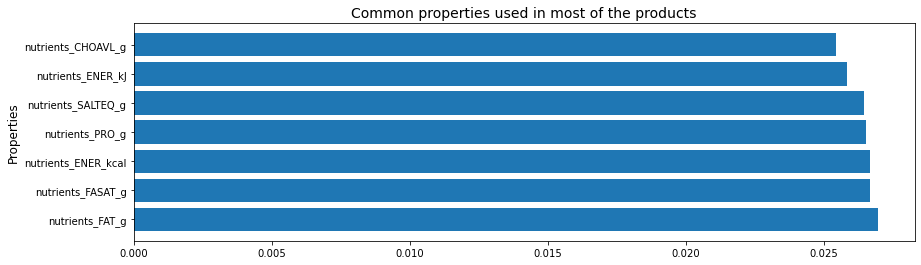

In [18]:
#Common properties used in most of the products
fig, ax = plt.subplots(figsize = (14,4))
ax.barh(to_1D(product_properties["property_name"]).value_counts(normalize=True).head(13).loc[lambda x : x<0.027340].index,
        to_1D(product_properties["property_name"]).value_counts(normalize=True).head(13).loc[lambda x : x<0.027340].values)
ax.set_ylabel("Properties", size = 12)
ax.set_title("Common properties used in most of the products", size = 14)

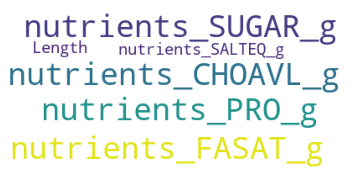

In [19]:
# Create stopword list:"nutrients_SUGAR_g","nutrients_FASAT_g","nutrients_PRO_g","nutrients_CHOAVL_g","nutrients_ENER_kJ","nutrients_SALTEQ_g","nutrients_ENER_kJ"
stopwords = set(STOPWORDS)
stopwords.update(["visibility", "information_provider", "last_synchronized", "subproduct_ean",
                  "statistics_code","object","dtype","product_name","target_market",
                  "net_content","descriptor_code","last_time_of_change","trade_item_size",
                  "nutrient_comparison_type","minimum_trade_item_lifespan_from_time_of_production","brand_name",
                  "gpc_category_name","comparison_per_litre","packaging_marked_label_accreditation_code",
                  "validoo_country_of_origin","comparison_per_kilogram","comparison_drained_weight","comparison_per_piece",
                  "subproduct_ean","minimum_lifespan","marketing_message","import_classification","nutritional_claim",
                 "comparison_","packaging_marked_diet_allergen_code","Etikettnamn","bast_fore_datum"])
#Length, height, packaging_type, depth, width, gross_weight, vegansk
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(str(to_1D(product_properties["property_name"])))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 2. Apply association rule to find the rules between properties

In [20]:
#Conevrt data into boolean
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [21]:
#call the function to convert into boolean
property_bool = boolean_df(product_properties["property_name"], to_1D(product_properties["property_name"]).value_counts().keys())
property_bool.head(2)

,visibility,proclient_country_of_origin,package_size,statistics_code,package_description,last_synchronized,nutrients_FAT_g,nutrients_FASAT_g,nutrients_ENER_kcal,nutrients_PRO_g,...,nutrients_FIBTG_GR,nutrients_ENER_,nutrients_CU_MGM,nutrients_ZN_MGM,nutrients_CU_g,nutrients_ZN_g,nutrients_MN_MGM,nutrients_MN_g,nutrients_SE_g,nutrients_SE_MC
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


In [22]:
#encode values with 1 and 0
def hot_encode(x):
    if(x== False):
        return 0
    if(x == True):
        return 1

In [23]:
property_bool = property_bool.applymap(hot_encode)
property_bool.head(2)

,visibility,proclient_country_of_origin,package_size,statistics_code,package_description,last_synchronized,nutrients_FAT_g,nutrients_FASAT_g,nutrients_ENER_kcal,nutrients_PRO_g,...,nutrients_FIBTG_GR,nutrients_ENER_,nutrients_CU_MGM,nutrients_ZN_MGM,nutrients_CU_g,nutrients_ZN_g,nutrients_MN_MGM,nutrients_MN_g,nutrients_SE_g,nutrients_SE_MC
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#frq_items = apriori(property_bool, min_support = 0.05, use_colnames = True)
# MemoryError: Unable to allocate 130. GiB for an array with shape (21769, 3, 267441) and data type int64

#### Tried to apply association rule but memory error occured.

# 3. Recommender system.

Collaborative filtering

Cons: Require a good amount of information for them to generate a relevant product recommendation

In [25]:
#Pivot table with products  and ADMIN REF
df_items = orders.pivot_table(index='admin_reference', columns=['product_name'], values='quantity').fillna(0)
df_items.head(2)

product_name,"""3DTavla """"Home""""""","""Chupa Chups """"Want U"""" magnet""",1 Flak FantaMezzo & 1 Flak CocaCola 33cl,1 brett Coca-Cola Zero,1 brett Coca-Cola och 1 Brett 7-UP,1 brett Dr Pepper + 1 brett Pepsi Max,1 brett Fanta Exotic + 2 brett Fanta org,1 brett Pepsi Max + 1 After Eight 400g,1 brett Sprite + 2 brett Coca-Cola,1 brett Sprite Zero - PANTFRITT,...,ÄT - Twist 145 g 1 aug,ÄT- Dipmix Vitl &Gurka 24g - 16st,ÄT- Rocher 4-pack - 16st 15 juni,ÄT- Rocher 4-pack - 16st 29juni,Ägglåda för 6st ägg,Äggskallar skum - 1 kg,"Äggskallar skum - 2,8 kg",Äppel Salmiak Öra 1 kg påse,Äppel ananas Öra 1 kg påse,"Äpple/kanelkola 1,3 kg"
admin_reference,,,,,,,,,,,,,,,,,,,,,
O000000802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O000001094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#function to get recommendation with simple correlation
def get_recommendations(df, item):
    """Generate a set of product recommendations using item-based collaborative filtering.
    
    Args:
        df (dataframe): Pandas dataframe containing matrix of items purchased.
        item (string): Column name for target item. 
        
    Returns: 
        recommendations (dataframe): Pandas dataframe containing product recommendations. 
    """
    recommendations = df.corrwith(df[item])
    recommendations.dropna(inplace=True)
    recommendations = pd.DataFrame(recommendations, columns=['correlation']).reset_index()
    recommendations = recommendations.sort_values(by='correlation', ascending=False)
    
    return recommendations

In [27]:
# Top 5 recommendation for 1 brett Coca-Cola Zero
recommendations = get_recommendations(df_items, '1 brett Coca-Cola Zero')
recommendations.head()

,product_name,correlation
3,1 brett Coca-Cola Zero,1.000000
10,1 brett Sprite Zero Pantfri,0.058155
1749,Fanta Orange 33 cl - 10-pack,0.025848
4169,Paw Patrol Godisarmband,0.020413
3829,Nick's Dark Chocolate 25g - 30 st,0.017058


In [28]:
# Top 5 recommendation for Chupa Chups ""Want U"" magnet
recommendations = get_recommendations(df_items, '"Chupa Chups ""Want U"" magnet"')
recommendations.head()

,product_name,correlation
1,"""Chupa Chups """"Want U"""" magnet""",1.000000
1072,Chupa Chups MISS U Magnet,0.146309
1075,Chupa Chups Thank You magnet,0.089598
4044,PIÑATA BRANDBIL,0.076940
5233,Stilettkam Stor,0.069560


# 4. Recommender system for properties

In [29]:
#load product properties data collected from API
properties = pd.read_csv("properties_values_new.csv")

In [30]:
#drop values which has empty property
properties = properties.drop(properties[properties.property_name == '0' ].index)
properties.columns = ['sku', 'property_name']

In [31]:
#join property and product sum data
product_properties = pd.merge(properties,product_sum,how='left',on='sku')
product_properties = product_properties.dropna()
product_properties.head(2)

,sku,property_name,product_name,quantity_sum
0,COC520,"['visibility', 'information_provider', 'last_s...",Monster Lewis Hamilton 50 cl x 24 st,167.0
1,SÄL427025,"['package_size', 'nutrient_comparison_type', '...",SMAKIS APELSIN KRAV BRICK 25CL - 27 st,82.0


In [32]:
#prepare a basket
product_properties["property_name"] = product_properties["property_name"].apply(eval)
product_properties = product_properties.drop(["product_name"],axis = 1)
product_properties.head(2)

,sku,property_name,quantity_sum
0,COC520,"[visibility, information_provider, last_synchr...",167.0
1,SÄL427025,"[package_size, nutrient_comparison_type, nutri...",82.0


In [33]:
#explode data from the quantity and sku
product_properties.reset_index(inplace=True)
rows = []
_ = product_properties.apply(lambda row: [rows.append( [row['sku'],row['quantity_sum'], nn]) 
                         for nn in row.property_name], axis=1)

In [34]:
#create a dataframe for recommendation
df_new = pd.DataFrame(rows, columns=['sku','quantity_sum','property_name'])
df_new.head(2)

,sku,quantity_sum,property_name
0,COC520,167.0,visibility
1,COC520,167.0,information_provider


In [35]:
#pivot data for the recommendations
df_items = df_new.pivot_table(index='sku', columns=['property_name'], values='quantity_sum').fillna(0)
df_items.head(2)

property_name,Etikettnamn,allergen_contains,allergen_may_contain,bast_fore_datum,brand_name,child_item_gtin,child_item_quantity,comparison_,comparison_drained_weight,comparison_per_kilogram,...,product_name,statistics_code,subproduct_ean,target_market,trade_item_size,validoo_country_of_origin,vegansk,veganskt,visibility,width
sku,,,,,,,,,,,,,,,,,,,,,
1-KR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1954.0,0.0
2-KR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,865.0,0.0


In [36]:
#clean the properties
df_items = df_items.drop(["visibility", "information_provider", "last_synchronized", "subproduct_ean",
                  "statistics_code","product_name","target_market",
                  "net_content","descriptor_code","last_time_of_change","trade_item_size",
                  "nutrient_comparison_type","minimum_trade_item_lifespan_from_time_of_production","brand_name",
                  "gpc_category_name","comparison_per_litre","packaging_marked_label_accreditation_code",
                  "validoo_country_of_origin","comparison_per_kilogram","comparison_drained_weight","comparison_per_piece",
                  "subproduct_ean","minimum_lifespan","marketing_message","import_classification","nutritional_claim",
                 "comparison_","packaging_marked_diet_allergen_code","Etikettnamn","bast_fore_datum"],axis=1)

In [37]:
# Top 10 recommendation for nutrients_VITD_g
recommendations = get_recommendations(df_items, 'nutrients_VITD_g')
recommendations.head(10)

,property_name,correlation
66,nutrients_VITD_g,1.000000
31,nutrients_FOLDFE_g,0.998888
12,nutrients_BIOT_g,0.873842
65,nutrients_VITD_MC,0.784433
30,nutrients_FOLDFE_MC,0.784102
11,nutrients_BIOT_MC,0.718722
60,nutrients_VITB12_g,0.429269
41,nutrients_NIA_g,0.428352
62,nutrients_VITB6_g,0.424942
59,nutrients_VITB12_MC,0.356558


In [38]:
# Top 10 recommendation for nutrients_VITE_MGM

recommendations = get_recommendations(df_items, 'nutrients_VITE_MGM')
recommendations.head(10)

,property_name,correlation
68,nutrients_VITE_g,1.000000
67,nutrients_VITE_MGM,1.000000
58,nutrients_THIA_g,0.643613
57,nutrients_THIA_MGM,0.628855
64,nutrients_VITC_g,0.602934
63,nutrients_VITC_MGM,0.505112
12,nutrients_BIOT_g,0.486017
11,nutrients_BIOT_MC,0.399298
60,nutrients_VITB12_g,0.236689
41,nutrients_NIA_g,0.235563


In [39]:
# Top 10 recommendation for veganskt
recommendations = get_recommendations(df_items, 'veganskt')
recommendations.head(10)

,property_name,correlation
77,veganskt,1.000000
7,gelatin,0.550525
74,pof,0.463246
26,nutrients_FAT_,0.189314
13,nutrients_CHOAVL_,0.105724
55,nutrients_SUGAR_,0.103528
14,nutrients_CHOAVL_g,0.095929
46,nutrients_PRO_g,0.092369
51,nutrients_SALTEQ_g,0.092314
21,nutrients_ENER_kcal,0.091765


# Properties with values.

In [40]:
#load product properties data collected from API
properties = pd.read_csv("properties_values.csv")
properties.head(2)

,sku_id,property_name,value
0,SÄL427025,package_size,27.0
1,SÄL427025,nutrient_comparison_type,100 g


In [41]:
#remove dummy property
properties = properties.loc[~properties.property_name.isin(["visibility", "information_provider", "last_synchronized", "subproduct_ean",
                  "statistics_code","product_name","target_market",
                  "net_content","descriptor_code","last_time_of_change","trade_item_size",
                  "nutrient_comparison_type","minimum_trade_item_lifespan_from_time_of_production","brand_name",
                  "gpc_category_name","comparison_per_litre","packaging_marked_label_accreditation_code",
                  "validoo_country_of_origin","comparison_per_kilogram","comparison_drained_weight","comparison_per_piece",
                  "subproduct_ean","minimum_lifespan","marketing_message","import_classification","nutritional_claim",
                 "comparison_","packaging_marked_diet_allergen_code","Etikettnamn","bast_fore_datum"])]

In [42]:
properties.property_name.value_counts().head(2)

proclient_country_of_origin    1187
package_description            1131
Name: property_name, dtype: int64

In [43]:
# #drop the rows where the property details are empty.
# properties = properties[properties['property_name'] != '0']
# properties.head(2)
# # revove the list brackets
# properties['property_name'] = properties['property_name'].apply(lambda x: x.lstrip('['))
# properties['property_name'] = properties['property_name'].apply(lambda x: x.rstrip(']'))
# properties.head(2)

In [44]:
# properties.pivot(index='sku_id', columns='property_name', values='value')

In [45]:
table = pd.pivot_table(properties, values='value', index=['sku_id'],
                    columns=['property_name'], aggfunc=np.sum)
table.head(2)

property_name,allergen_contains,allergen_may_contain,child_item_gtin,child_item_quantity,depth,descriptive_size,free_from_palmoil,gelatin,gelatinfri,gross_weight,...,nutrients_ZN_MGM,nutrients_ZN_g,package_description,package_size,packaging_type,pof,proclient_country_of_origin,vegansk,veganskt,width
sku_id,,,,,,,,,,,,,,,,,,,,,
1-KR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,* 1 st,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2-KR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,*1 ST,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#fill zero for Nan values
table = table.fillna(0)
table.head(2)

property_name,allergen_contains,allergen_may_contain,child_item_gtin,child_item_quantity,depth,descriptive_size,free_from_palmoil,gelatin,gelatinfri,gross_weight,...,nutrients_ZN_MGM,nutrients_ZN_g,package_description,package_size,packaging_type,pof,proclient_country_of_origin,vegansk,veganskt,width
sku_id,,,,,,,,,,,,,,,,,,,,,
1-KR,0,0,0,0,0,0,0,0,0,0,...,0,0,* 1 st,1.0,0,0,0,0,0,0
2-KR,0,0,0,0,0,0,0,0,0,0,...,0,0,*1 ST,1.0,0,0,0,0,0,0


In [48]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1239 entries, 1-KR to ZOBR1
Data columns (total 81 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   allergen_contains            1239 non-null   object
 1   allergen_may_contain         1239 non-null   object
 2   child_item_gtin              1239 non-null   object
 3   child_item_quantity          1239 non-null   object
 4   depth                        1239 non-null   object
 5   descriptive_size             1239 non-null   object
 6   free_from_palmoil            1239 non-null   object
 7   gelatin                      1239 non-null   object
 8   gelatinfri                   1239 non-null   object
 9   gross_weight                 1239 non-null   object
 10  height                       1239 non-null   object
 11  nutrients_BIOT_MC            1239 non-null   object
 12  nutrients_BIOT_g             1239 non-null   object
 13  nutrients_CHOAVL_            1239 

In [49]:
table.nutrients_NACL_g.unique()

array([0, '0.2', '0.3', '0.0', '1.35', '0.18', '0.1', '0.4', '0.02',
       '0.43', '0.25', '0.07', '0.32', '0.27', '0.59', '0.03', '0.01',
       '0.5', '0.85', '2.7', '0.08', '0.63', '0.7', '0.13', '0.23',
       '0.48', '0.6', '0.15', '1.8', '0.11', '0.14', '0.12', '0.98',
       '2.0', '2.1'], dtype=object)

 Numerical values :
 child_item_gtin,child_item_quantity,depth,width,package_size,nutrients_ZN_g,nutrients_ZN_MGM,nutrients_VITE_g,nutrients_VITE_MGM
 nutrients_VITD_g,nutrients_VITD_MC,nutrients_VITC_g,nutrients_VITC_MGM,nutrients_VITB6_g,nutrients_VITB6_MGM,nutrients_VITB12_g,
nutrients_VITB12_MGM, nutrients_VITB12_MC,nutrients_THIA_g,nutrients_THIA_MGM,nutrients_SUGAR_g, nutrients_SUGAR_,nutrients_STARCH_g
#nutrients_SE_MC,
 nutrients_FASAT_g            1258 non-null   object
 26  nutrients_FAT_               1258 non-null   object
 27  nutrients_FAT_g              1258 non-null   object
 28  nutrients_FE_MGM             1258 non-null   object
 29  nutrients_FE_g               1258 non-null   object
 30  nutrients_FIBTG_GR           1258 non-null   object
 31  nutrients_FIBTG_g            1258 non-null   object
 32  nutrients_FOLDFE_MC          1258 non-null   object
 33  nutrients_FOLDFE_g           1258 non-null   object
 34  nutrients_K_MGM              1258 non-null   object
 35  nutrients_K_g                1258 non-null   object
 36  nutrients_MG_MGM             1258 non-null   object
 37  nutrients_MG_g               1258 non-null   object
 38  nutrients_MN_MGM             1258 non-null   object
 39  nutrients_MN_g               1258 non-null   object
 40  nutrients_NACL_g             1258 non-null   object
 41  nutrients_NA_g               1258 non-null   object
 42  nutrients_NIA_MGM            1258 non-null   object
 43  nutrients_NIA_g              1258 non-null   object
 44  nutrients_PANTAC_MGM         1258 non-null   object
 45  nutrients_PANTAC_g           1258 non-null   object
 46  nutrients_POLYL_g            1258 non-null   object
 47  nutrients_PRO_               1258 non-null   object
 48  nutrients_PRO_g              1258 non-null   object
 49  nutrients_RIBF_MGM           1258 non-null   object
 50  nutrients_RIBF_g             1258 non-null   object
 51  nutrients_SALTEQ_            1258 non-null   object
 52  nutrients_SALTEQ_g
# Categorical values: 
#allergen_contains, allergen_may_contain,veganskt,vegansk,proclient_country_of_origin,pof,packaging_type,


#others:
# package_description

In [50]:
# Seperate reccommender system but need more time

# 5. Recommender system for properties+values

1. join property and orders data
2. Transform the data(Prepared as a basket)
3. Filter the products which are most sold *Filter the products which are most sold( grater than 100 quanty sales)
4. Property is recommended with value.
5. 

In [51]:
#load product properties data collected from API
properties = pd.read_csv("properties_values_final_one.csv")


In [52]:
#drop values which has empty property
properties = properties.drop(properties[properties.property_name == '0' ].index)
properties.columns = ['sku', 'property_name']

In [53]:
#join property and product sum data
product_properties = pd.merge(properties,product_sum,how='left',on='sku')
product_properties = product_properties.dropna()
product_properties.head(2)

,sku,property_name,product_name,quantity_sum
0,COC520,"['nutrients_RIBF_MGM-0.7', 'package_descriptio...",Monster Lewis Hamilton 50 cl x 24 st,167.0
1,SÄL427025,"['package_size-27.0', 'nutrients_ENER_kJ-150.0...",SMAKIS APELSIN KRAV BRICK 25CL - 27 st,82.0


In [54]:
#prepare a basket
product_properties["property_name"] = product_properties["property_name"].apply(eval)
product_properties = product_properties.drop(["product_name"],axis = 1)
product_properties.head(2)

,sku,property_name,quantity_sum
0,COC520,"[nutrients_RIBF_MGM-0.7, package_description-*...",167.0
1,SÄL427025,"[package_size-27.0, nutrients_ENER_kJ-150.0, p...",82.0


In [55]:
#explode data from the quantity and sku
product_properties.reset_index(inplace=True)
rows = []
_ = product_properties.apply(lambda row: [rows.append( [row['sku'],row['quantity_sum'], nn]) 
                         for nn in row.property_name], axis=1)

In [56]:
#create a dataframe for recommendation
df_new = pd.DataFrame(rows, columns=['sku','quantity_sum','property_name'])
# consider only products which are sold more than once
df_new = df_new[df_new['quantity_sum']>=100]
df_new.head(2)

,sku,quantity_sum,property_name
0,COC520,167.0,nutrients_RIBF_MGM-0.7
1,COC520,167.0,package_description-* 24 ST


In [57]:
#pivot data for the recommendations
df_items = df_new.pivot_table(index='sku', columns=['property_name'], values='quantity_sum').fillna(0)
df_items.head(2)

property_name,allergen_contains-AE,allergen_contains-AM,allergen_contains-AN,allergen_contains-AP,allergen_contains-AU,allergen_contains-AW,allergen_contains-AY,allergen_contains-GB,allergen_contains-GO,allergen_contains-ML,...,width-75.0,width-77.0,width-79.0,width-800.0,width-85.0,width-89.0,width-90.0,width-94.0,width-95.0,width-98.0
sku,,,,,,,,,,,,,,,,,,,,,
1-KR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2-KR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Top 10 recommendation for nutrients_RIBF_MGM-0.7
recommendations = get_recommendations(df_items, 'nutrients_RIBF_MGM-0.7')
recommendations.head(10)

,property_name,correlation
1755,nutrients_RIBF_MGM-0.7,1.000000
368,descriptive_size-500ml,0.934547
808,nutrients_CHOAVL_g-12.0,0.922867
2389,width-269.0,0.849462
212,depth-402.0,0.849462
1629,nutrients_NIA_MGM-8.5,0.840177
2078,nutrients_VITB6_MGM-0.8,0.840177
1634,nutrients_NIA_g-0.009,0.840177
2073,nutrients_VITB12_MC-2.5,0.840177
438,gross_weight-13090.0,0.805723


In [59]:
# Top 10 recommendation for nutrients_VITB6_MGM-0.8	
recommendations = get_recommendations(df_items, 'nutrients_VITB6_MGM-0.8')
recommendations.head(10)

,property_name,correlation
1629,nutrients_NIA_MGM-8.5,1.000000
1634,nutrients_NIA_g-0.009,1.000000
2073,nutrients_VITB12_MC-2.5,1.000000
2078,nutrients_VITB6_MGM-0.8,1.000000
669,height-170.0,0.849553
1755,nutrients_RIBF_MGM-0.7,0.840177
368,descriptive_size-500ml,0.815091
808,nutrients_CHOAVL_g-12.0,0.775994
2389,width-269.0,0.748929
212,depth-402.0,0.748929


In [60]:
# Top 10 recommendation for nutrients_CHOAVL_-93.7
recommendations = get_recommendations(df_items, 'nutrients_CHOAVL_-93.7')
recommendations.head(10)

,property_name,correlation
1285,nutrients_ENER_kcal-401.0,1.000000
918,nutrients_CHOAVL_g-93.7,1.000000
1503,nutrients_FAT_g-2.9,1.000000
1073,nutrients_ENER_kJ-1702.0,1.000000
788,nutrients_CHOAVL_-93.7,1.000000
1917,nutrients_SUGAR_-69.4,1.000000
2147,"package_description-* 2,5 KG",0.947335
1394,nutrients_FASAT_g-1.6,0.593445
2250,package_size-2.5,0.361390
1667,nutrients_PRO_g-0.1,0.239585


Seperate recommender system can be developed, but require more features and need time to build a model 

# 6 Nearest Neighbour item based recommender system

In [61]:
# consider only products which are sold more than once
df_new = df_new[df_new['quantity_sum']>=100]

In [62]:
#pivot data for the recommendations
df_items = df_new.pivot_table(index='property_name', columns=['sku'], values='quantity_sum').fillna(0)
df_items.head(2)

sku,1-KR,2-KR,ACT2960,ACT4311,ACT4321,ACT4341,ACT4351,ARO252,ARO2531,ARO280,...,WEB9394,WEB95898,WEB973370,WEB985,WEB9951,WEBZ0001,WRI266005,WRI348812,WRI387658,WRI396494
property_name,,,,,,,,,,,,,,,,,,,,,
allergen_contains-AE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
allergen_contains-AM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,377.0,599.0,149.0,0.0,112.0,0.0,0.0,0.0,0.0


In [63]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
#build a recommender system
df_matrix = csr_matrix(df_items.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [64]:
#take a random property in a dataset 
query_index = np.random.choice(df_items.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(df_items.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 10)

1812


In [65]:
#show the top 10 recommended property
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(df_items.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, df_items.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for nutrients_SALTEQ_g-0.49:

1: package_description-* 23st, with distance of 0.0:
2: nutrients_SALTEQ_g-0.49, with distance of 0.0:
3: package_size-23.0, with distance of 0.0:
4: nutrients_ENER_kJ-2267.0, with distance of 0.0:
5: nutrients_CHOAVL_-55.0, with distance of 0.0:
6: nutrients_SUGAR_-49.0, with distance of 0.5665273900482297:
7: nutrients_PRO_g-5.3, with distance of 0.660297661973263:
8: nutrients_FIBTG_g-1.3, with distance of 0.67676324590938:
9: nutrients_FASAT_g-19.0, with distance of 0.850755725467368:


# Campared the results of spearson correlation and Nearest neighbour(Cosine similarity

Most of the answers are similar


Not able to build a recommender for the property value specific using property.
As we dont have data which explains the most of the property values, such as nutrients_PRO_g (from 0 to some value)

# 7. Most sold products(>1000) recommender system

In [142]:
#load product properties data collected from API
properties = pd.read_csv("properties_values_final_one.csv")

In [143]:
#drop values which has empty property
properties = properties.drop(properties[properties.property_name == '0' ].index)
properties.columns = ['sku', 'property_name']

In [144]:
#join property and product sum data
product_properties = pd.merge(properties,product_sum,how='left',on='sku')
product_properties = product_properties.dropna()
product_properties.head(2)

,sku,property_name,product_name,quantity_sum
0,COC520,"['nutrients_RIBF_MGM-0.7', 'package_descriptio...",Monster Lewis Hamilton 50 cl x 24 st,167.0
1,SÄL427025,"['package_size-27.0', 'nutrients_ENER_kJ-150.0...",SMAKIS APELSIN KRAV BRICK 25CL - 27 st,82.0


In [145]:
product_properties = product_properties[product_properties['quantity_sum']>=100]

In [146]:
#prepare a basket
product_properties["property_name"] = product_properties["property_name"].apply(eval)
product_properties = product_properties.drop(["product_name"],axis = 1)
product_properties.head(2)

,sku,property_name,quantity_sum
0,COC520,"[nutrients_RIBF_MGM-0.7, package_description-*...",167.0
4,SKÅ5060,"[allergen_contains-AW, nutrients_ENER_kJ-1418....",1754.0


In [147]:
#explode data from the quantity and sku
product_properties.reset_index(inplace=True)
rows = []
_ = product_properties.apply(lambda row: [rows.append( [row['sku'],row['quantity_sum'], nn]) 
                         for nn in row.property_name], axis=1)

In [148]:
#create a dataframe for recommendation
df_new = pd.DataFrame(rows, columns=['sku','quantity_sum','property_name'])

In [149]:
# consider only products which are sold more than 1000
df_new = df_new[df_new['quantity_sum']>=1000]
df_new.head(2)

,sku,quantity_sum,property_name
26,SKÅ5060,1754.0,allergen_contains-AW
27,SKÅ5060,1754.0,nutrients_ENER_kJ-1418.0


In [150]:
#pivot data for the recommendations
df_items = df_new.pivot_table(index='sku', columns=['property_name'], values='quantity_sum').fillna(0)
df_items.head(2)

property_name,allergen_contains-AM,allergen_contains-AN,allergen_contains-AW,allergen_contains-AY,allergen_may_contain-AE,allergen_may_contain-AM,allergen_may_contain-AN,allergen_may_contain-AP,allergen_may_contain-AW,allergen_may_contain-SA,...,width-193.0,width-195.0,width-200.0,width-210.0,width-220.0,width-225.0,width-260.0,width-263.0,width-271.0,width-490.0
sku,,,,,,,,,,,,,,,,,,,,,
1-KR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATBOX001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
# Top 10 recommendation for nutrients_CHOAVL_g-52.0	
recommendations = get_recommendations(df_items, 'nutrients_CHOAVL_g-52.0')
recommendations.head(10)

,property_name,correlation
138,nutrients_CHOAVL_g-52.0,1.000000
304,nutrients_PRO_g-6.2,1.000000
128,nutrients_CHOAVL_-52.0,0.939715
25,child_item_quantity-42,0.939715
37,depth-259.0,0.939715
396,package_description-* 42 st,0.939715
441,proclient_country_of_origin-LT,0.939715
19,child_item_gtin-07622210865335,0.939715
69,descriptive_size-43 G,0.939715
316,nutrients_SALTEQ_g-0.13,0.939715


In [76]:
# Top 10 recommendation for nutrients_CHOAVL_g-52.0	
recommendations = get_recommendations(df_items, 'nutrients_SALTEQ_g-0.13')
recommendations.head(10)

,property_name,correlation
195,nutrients_ENER_kJ-2357.0,1.0
19,child_item_gtin-07622210865335,1.0
420,package_size-42.0,1.0
69,descriptive_size-43 G,1.0
122,height-99.0,1.0
128,nutrients_CHOAVL_-52.0,1.0
396,package_description-* 42 st,1.0
441,proclient_country_of_origin-LT,1.0
37,depth-259.0,1.0
451,width-132.0,1.0


##### Continuation of manually identify the property value.

In [161]:
cols = [col for col in df_items.columns if 'nutrients_SUGAR_g' in col]
print(cols)

['nutrients_SUGAR_g-0.5', 'nutrients_SUGAR_g-1.9', 'nutrients_SUGAR_g-11.0', 'nutrients_SUGAR_g-13.2', 'nutrients_SUGAR_g-2.8', 'nutrients_SUGAR_g-32.0', 'nutrients_SUGAR_g-45.6', 'nutrients_SUGAR_g-47.0', 'nutrients_SUGAR_g-48.3', 'nutrients_SUGAR_g-50.0', 'nutrients_SUGAR_g-51.0', 'nutrients_SUGAR_g-53.3', 'nutrients_SUGAR_g-54.0', 'nutrients_SUGAR_g-54.5', 'nutrients_SUGAR_g-57.0', 'nutrients_SUGAR_g-59.0', 'nutrients_SUGAR_g-60.0', 'nutrients_SUGAR_g-61.0', 'nutrients_SUGAR_g-62.0', 'nutrients_SUGAR_g-63.0', 'nutrients_SUGAR_g-63.2', 'nutrients_SUGAR_g-65.0', 'nutrients_SUGAR_g-66.0', 'nutrients_SUGAR_g-67.0', 'nutrients_SUGAR_g-68.0', 'nutrients_SUGAR_g-8.3', 'nutrients_SUGAR_g-8.6', 'nutrients_SUGAR_g-9.1']


In [162]:
df_items.reset_index(inplace=True)
manually_analysis = df_items[['nutrients_SUGAR_g-0.5', 'nutrients_SUGAR_g-1.9', 'nutrients_SUGAR_g-11.0', 'nutrients_SUGAR_g-13.2', 'nutrients_SUGAR_g-2.8', 'nutrients_SUGAR_g-32.0', 'nutrients_SUGAR_g-45.6', 'nutrients_SUGAR_g-47.0', 'nutrients_SUGAR_g-48.3', 'nutrients_SUGAR_g-50.0', 'nutrients_SUGAR_g-51.0', 'nutrients_SUGAR_g-53.3', 'nutrients_SUGAR_g-54.0', 'nutrients_SUGAR_g-54.5', 'nutrients_SUGAR_g-57.0', 'nutrients_SUGAR_g-59.0', 'nutrients_SUGAR_g-60.0', 'nutrients_SUGAR_g-61.0', 'nutrients_SUGAR_g-62.0', 'nutrients_SUGAR_g-63.0', 'nutrients_SUGAR_g-63.2', 'nutrients_SUGAR_g-65.0', 'nutrients_SUGAR_g-66.0', 'nutrients_SUGAR_g-67.0', 'nutrients_SUGAR_g-68.0', 'nutrients_SUGAR_g-8.3', 'nutrients_SUGAR_g-8.6', 'nutrients_SUGAR_g-9.1']]
manually_analysis.head()

property_name,nutrients_SUGAR_g-0.5,nutrients_SUGAR_g-1.9,nutrients_SUGAR_g-11.0,nutrients_SUGAR_g-13.2,nutrients_SUGAR_g-2.8,nutrients_SUGAR_g-32.0,nutrients_SUGAR_g-45.6,nutrients_SUGAR_g-47.0,nutrients_SUGAR_g-48.3,nutrients_SUGAR_g-50.0,...,nutrients_SUGAR_g-62.0,nutrients_SUGAR_g-63.0,nutrients_SUGAR_g-63.2,nutrients_SUGAR_g-65.0,nutrients_SUGAR_g-66.0,nutrients_SUGAR_g-67.0,nutrients_SUGAR_g-68.0,nutrients_SUGAR_g-8.3,nutrients_SUGAR_g-8.6,nutrients_SUGAR_g-9.1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1027.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Content Based recommendation system for products

In [77]:
# # Import
# from sklearn.metrics.pairwise import linear_kernel
# from sklearn.feature_extraction.text import CountVectorizer

# #dummy function to handle lists
# def dummy(doc):
#     return doc

# tfv = CountVectorizer(
#     tokenizer=dummy,
#     preprocessor=dummy,
# )
# # Fitting the TF-IDF on the 'property_name' text
# tfv_matrix = tfv.fit_transform(product_properties['property_name'])

# # Compute the cosine similarity matrix
# cosine_sim = linear_kernel(tfv_matrix, tfv_matrix)

# indices = pd.Series(product_properties.index, index=product_properties['sku']).drop_duplicates()

# # Function that takes in movie title as input and outputs most similar movies
# def get_recommendations(title, cosine_sim=cosine_sim):
#     # Get the index of the movie that matches the title
#     idx = indices[title]

#     # Get the pairwsie similarity scores of all movies with that movie
#     sim_scores = list(enumerate(cosine_sim[idx]))

#     # Sort the movies based on the similarity scores
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

#     # Get the scores of the 10 most similar movies
#     sim_scores = sim_scores[1:11]

#     # Get the movie indices
#     pro_indices = [i[0] for i in sim_scores]

#     # Return the top 10 most similar movies
#     return product_properties['sku'].iloc[pro_indices]

# # recommendations
# get_recommendations('COC520')

# Manually finding the best property value task. (Can be implemented using regression and classification algorithms) 

In [138]:
#load product properties data collected from API
properties = pd.read_csv("properties_values.csv")
#remove unwanted properties
properties = properties.loc[~properties.property_name.isin(["visibility", "information_provider", "last_synchronized", "subproduct_ean",
                  "statistics_code","product_name","target_market",
                  "net_content","descriptor_code","last_time_of_change","trade_item_size",
                  "nutrient_comparison_type","minimum_trade_item_lifespan_from_time_of_production","brand_name",
                  "gpc_category_name","comparison_per_litre","packaging_marked_label_accreditation_code",
                  "validoo_country_of_origin","comparison_per_kilogram","comparison_drained_weight","comparison_per_piece",
                  "subproduct_ean","minimum_lifespan","marketing_message","import_classification","nutritional_claim",
                 "comparison_","packaging_marked_diet_allergen_code","Etikettnamn","bast_fore_datum"])]
table = pd.pivot_table(properties, values='value', index=['sku_id'],columns=['property_name'], aggfunc=np.sum)
table.reset_index(inplace=True)
table.head(2)

property_name,sku_id,allergen_contains,allergen_may_contain,child_item_gtin,child_item_quantity,depth,descriptive_size,free_from_palmoil,gelatin,gelatinfri,...,nutrients_ZN_MGM,nutrients_ZN_g,package_description,package_size,packaging_type,pof,proclient_country_of_origin,vegansk,veganskt,width
0,1-KR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,* 1 st,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2-KR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,*1 ST,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
properties.head()

,sku_id,property_name,value
0,SÄL427025,package_size,27.0
2,SÄL427025,nutrients_ENER_kJ,150.0
4,SÄL427025,package_description,* 27 st
12,SÄL427025,descriptive_size,250 ml
15,SÄL427025,height,107.0


In [140]:
#rename the column names to join the dataframe
properties.columns = ['sku_id', 'property_name', 'value']
#join the dataframes
manual_property = pd.merge(properties.drop(['property_name', 'value'],axis=1),table[['nutrients_VITE_MGM','sku_id']],how='left',on='sku_id')
#fill NaN with zero values
manual_property = manual_property.fillna(0)
manual_property.head(2)

,sku_id,nutrients_VITE_MGM
0,SÄL427025,0
1,SÄL427025,0


In [154]:
manual_property.nutrients_VITE_MGM.value_counts()

0       20370
0.54      186
1.4       162
1.8        65
1.2        62
2.4        28
Name: nutrients_VITE_MGM, dtype: int64

In [125]:
#rename the column names to join the dataframe
manual_property.columns = ['sku', 'nutrients_VITE_MGM']
#join the dataframes
manual_property = pd.merge(manual_property,product_properties[['sku','quantity_sum']],how='left',on='sku')
manual_property.head(2)

,sku,nutrients_VITE_MGM,quantity_sum
0,SÄL427025,0,NaN
1,SÄL427025,0,NaN


In [127]:
manual_property.quantity_sum.value_counts()

101.0     90
102.0     89
117.0     85
131.0     75
132.0     71
          ..
865.0      2
1954.0     2
7550.0     2
4020.0     1
1179.0     1
Name: quantity_sum, Length: 296, dtype: int64

In [128]:
manual_property.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20873 entries, 0 to 20872
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sku                 20873 non-null  object 
 1   nutrients_VITE_MGM  20873 non-null  object 
 2   quantity_sum        7241 non-null   float64
dtypes: float64(1), object(2)
memory usage: 652.3+ KB


In [135]:
#drop null values as the rows are repeated.
manual_property = manual_property.dropna()
#drop duplicate rows
manual_property = manual_property.drop_duplicates()
#remove the rows which contain 0
manual_property = manual_property[manual_property.nutrients_VITE_MGM != 0]
manual_property.head(2)

,sku,nutrients_VITE_MGM,quantity_sum
7604,COC1685,1.8,322.0
11093,COC1786,1.8,285.0


In [137]:
manual_property.groupby(by = ['nutrients_VITE_MGM']).sum()

,quantity_sum
nutrients_VITE_MGM,
1.8,607.0
